In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

Load Cifar100

In [28]:
dataset = datasets.CIFAR100(root='./data',
                                 train=True,
                                 download=True)

Files already downloaded and verified


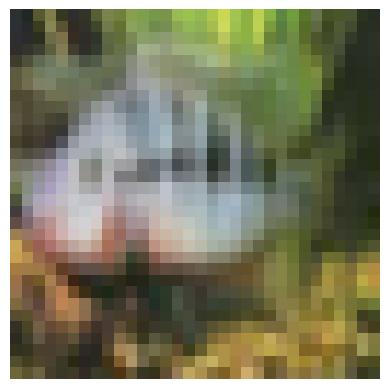

In [29]:
plt.imshow(dataset[4][0])
plt.axis('off')
plt.show()

In [30]:
dataset[4][0].size

(32, 32)

In [31]:
class MyOwnCifar(torch.utils.data.Dataset):
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]


trans_actions = transforms.Compose([transforms.Resize(44),
                                   transforms.RandomCrop(32, padding=4),
                                   transforms.ToTensor()])

def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

In [32]:
# split dataset (train, valid)
train_dataset, test_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
test_dataset = MyOwnCifar(test_dataset, transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=1024,
                                           shuffle=True,
                                           pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=128)

In [33]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Model

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Dropouts
        self.dp_1 = nn.Dropout(0.2)
        self.dp_2 = nn.Dropout(0.2)

        # Norm
        self.bn_1 = torch.nn.BatchNorm2d(3)
        self.bn_2 = torch.nn.BatchNorm2d(64)
        self.bn_3 = torch.nn.BatchNorm2d(128)
        self.bn_4 = torch.nn.BatchNorm2d(256)

        # Convolutions
        self.conv_1 = torch.nn.Conv2d(3, 64, 3)
        self.conv_2 = torch.nn.Conv2d(64, 128, 3)
        self.conv_3 = torch.nn.Conv2d(128, 256, 3)

        # Linear layers
        self.fc1 = torch.nn.Linear(1024, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.out = torch.nn.Linear(256, 100)

    def forward(self, x):
        x = self.bn_1(x)
        x = self.conv_1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_2(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_3(x)
        x = self.conv_3(x)
        x = F.leaky_relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn_4(x)
        x = x.view(x.size(0), -1 )
        x = self.dp_1(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_2(x)
        x = self.fc2(x)
        x = F.relu(x)

        return self.out(x)

net = Net().to(device)
print(net)

Net(
  (dp_1): Dropout(p=0.2, inplace=False)
  (dp_2): Dropout(p=0.2, inplace=False)
  (bn_1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=100, bias=True)
)


In [35]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [36]:
summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 64, 30, 30]           1,792
       BatchNorm2d-3           [-1, 64, 15, 15]             128
            Conv2d-4          [-1, 128, 13, 13]          73,856
       BatchNorm2d-5            [-1, 128, 6, 6]             256
            Conv2d-6            [-1, 256, 4, 4]         295,168
       BatchNorm2d-7            [-1, 256, 2, 2]             512
           Dropout-8                 [-1, 1024]               0
            Linear-9                  [-1, 512]         524,800
          Dropout-10                  [-1, 512]               0
           Linear-11                  [-1, 256]         131,328
           Linear-12                  [-1, 100]          25,700
Total params: 1,053,546
Trainable params: 1,053,546
Non-trainable params: 0
---------------------------

In [37]:
def learn_net(net, criterion ,optimizer, num_epochs):
    train_acc = []
    test_acc = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_items = 0.0
        running_loss_test = 0.0
        running_items_test = 0.0
        running_right = 0.0
        running_right_test = 0.0

        net.train()
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_items += len(labels)
            running_right += (labels == torch.max(outputs, 1)[1]).sum()

        running_right = running_right.item()
        print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
            f'Loss_train: {running_loss / (i + 1):.3f}. ' \
            f'Acc: {running_right / running_items:.3f}.', end=' ')
        acc = running_right / running_items
        train_acc.append(acc)
        # print(type(acc), acc, train_acc)
        running_loss, running_right, running_items = 0.0, 0.0, 0.0

        net.eval()
        for i, data in enumerate(test_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = net(inputs)

            loss = criterion(outputs, labels)

            running_loss_test += loss.item()
            running_items_test += len(labels)
            running_right_test += (labels == torch.max(outputs, 1)[1]).sum()

        running_right_test = running_right_test.item()
        print(f'Loss_test: {running_loss_test / (i + 1):.3f}. ' \
            f'Acc_test: {running_right_test / running_items_test:.3f}')
        test_acc.append(running_right_test / running_items_test)
        running_loss_test, running_items_test, running_right_test = 0.0, 0.0, 0.0

    print('Training is finished!')

    return train_acc, test_acc

In [38]:
train_acc, test_acc = learn_net(net, criterion, optimizer, 100)

Epoch [1/100]. Loss_train: 4.276. Acc: 0.049. Loss_test: 3.967. Acc_test: 0.078
Epoch [2/100]. Loss_train: 3.966. Acc: 0.081. Loss_test: 4.035. Acc_test: 0.080
Epoch [3/100]. Loss_train: 3.823. Acc: 0.104. Loss_test: 3.852. Acc_test: 0.104
Epoch [4/100]. Loss_train: 3.710. Acc: 0.123. Loss_test: 3.994. Acc_test: 0.112
Epoch [5/100]. Loss_train: 3.591. Acc: 0.144. Loss_test: 3.669. Acc_test: 0.133
Epoch [6/100]. Loss_train: 3.490. Acc: 0.163. Loss_test: 3.742. Acc_test: 0.146
Epoch [7/100]. Loss_train: 3.378. Acc: 0.182. Loss_test: 3.425. Acc_test: 0.184
Epoch [8/100]. Loss_train: 3.279. Acc: 0.202. Loss_test: 3.896. Acc_test: 0.141
Epoch [9/100]. Loss_train: 3.216. Acc: 0.213. Loss_test: 3.727. Acc_test: 0.159
Epoch [10/100]. Loss_train: 3.139. Acc: 0.228. Loss_test: 3.493. Acc_test: 0.206
Epoch [11/100]. Loss_train: 3.089. Acc: 0.237. Loss_test: 3.626. Acc_test: 0.172
Epoch [12/100]. Loss_train: 3.039. Acc: 0.248. Loss_test: 3.317. Acc_test: 0.214
Epoch [13/100]. Loss_train: 2.985. Ac

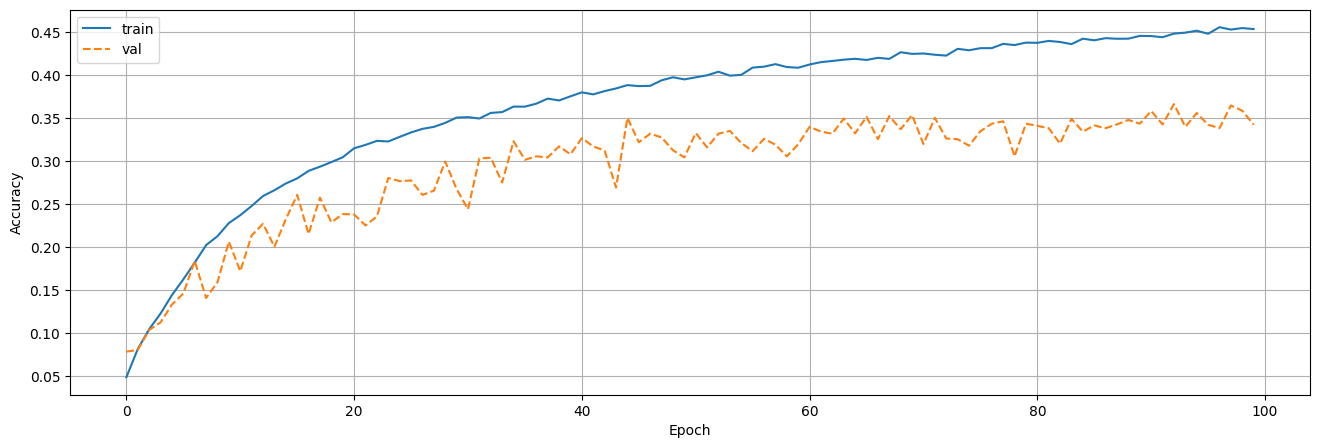

In [39]:
plt.figure(figsize = (16,5))
plt.plot(train_acc,'-',label = f'train')
plt.plot(test_acc,'--',label = f'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [40]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
print(resnet50)

C:\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\grayni/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:20<00:00, 4.94MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
summary(resnet50.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [42]:
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

In [43]:
resnet50.fc = nn.Linear(2048, 100)

summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [44]:
resnet50 = resnet50.to(device)

In [45]:
train_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, test_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
test_dataset = MyOwnCifar(test_dataset, test_transforms)

In [46]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=128,
                                           shuffle=False)

In [47]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [48]:
train_acc, test_acc = learn_net(resnet50, criterion, optimizer, 20)

Epoch [1/20]. Loss_train: 2.440. Acc: 0.416. Loss_test: 1.759. Acc_test: 0.530
Epoch [2/20]. Loss_train: 1.719. Acc: 0.539. Loss_test: 1.692. Acc_test: 0.546
Epoch [3/20]. Loss_train: 1.587. Acc: 0.567. Loss_test: 1.566. Acc_test: 0.575
Epoch [4/20]. Loss_train: 1.529. Acc: 0.578. Loss_test: 1.538. Acc_test: 0.577
Epoch [5/20]. Loss_train: 1.476. Acc: 0.590. Loss_test: 1.550. Acc_test: 0.580
Epoch [6/20]. Loss_train: 1.454. Acc: 0.597. Loss_test: 1.510. Acc_test: 0.587
Epoch [7/20]. Loss_train: 1.428. Acc: 0.601. Loss_test: 1.536. Acc_test: 0.580
Epoch [8/20]. Loss_train: 1.400. Acc: 0.606. Loss_test: 1.512. Acc_test: 0.594
Epoch [9/20]. Loss_train: 1.379. Acc: 0.612. Loss_test: 1.526. Acc_test: 0.589
Epoch [10/20]. Loss_train: 1.361. Acc: 0.615. Loss_test: 1.502. Acc_test: 0.575
Epoch [11/20]. Loss_train: 1.351. Acc: 0.619. Loss_test: 1.502. Acc_test: 0.583
Epoch [12/20]. Loss_train: 1.336. Acc: 0.623. Loss_test: 1.503. Acc_test: 0.580
Epoch [13/20]. Loss_train: 1.325. Acc: 0.625. Los

In [ ]:
plt.figure(figsize = (16,5))
plt.plot(train_acc,'-',label = f'train')
plt.plot(test_acc,'--',label = f'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()